In [ ]:
# Book-specific setup
# ===================
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [4]:
# Grab API key from google drive
# ==============================

# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1cNg43o1nDnvoc3sVWm2SpGKXZSQ2EQVV'
downloaded = drive.CreateFile({'id': file_id})
key = downloaded.GetContentString().rstrip()

In [ ]:
results = search_images_bing(key, 'brussels griffon dog')
images = results.attrgot('contentUrl')
len(images)

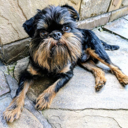

In [33]:
dest = 'images/brussels griffon.jpg'
download_url(images[0], dest)
image = Image.open(dest)
image.to_thumb(128, 128)

In [7]:
dog_breeds = 'brussels griffon', 'chihuahua', 'havanese'
path = Path('breeds')
if not path.exists():
    path.mkdir()
    for breed in dog_breeds:
        dest = (path/breed)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{breed} dog')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
filenames = get_image_files(path)
filenames

In [ ]:
failed = verify_images(filenames)
failed

In [ ]:
failed.map(Path.unlink)

In [11]:
# A DataBlock is a template for creating DataLoaders
dogs = DataBlock(
    # Dependent variable is an image, dependent variable is a category
    blocks=(ImageBlock, CategoryBlock),
    # Function to use for fetching image files (takes path argument)
    # The path argument is specified when we create an instance:
    #   dataloaders = dogs.dataloaders(path)
    get_items=get_image_files,
    # Use 20% of data selected randomly as validation set,
    # use the same 20% across runs by specifying seed
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # Use file's direcotry name as dependent variable
    get_y=parent_label,
    # To run images through model in paralell, they all must be of the same size
    item_tfms=Resize(128)
)

In [12]:
dls = dogs.dataloaders(path)

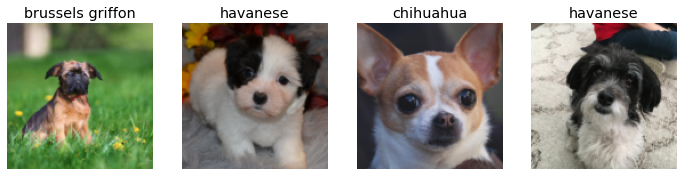

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

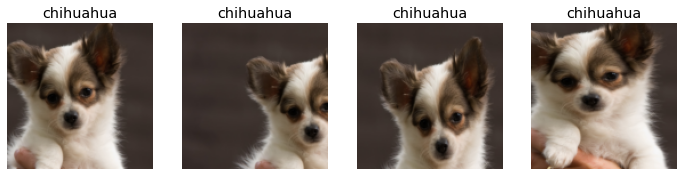

In [14]:
# Randomly select a cropped portion of the image for each epoch
# Select at least 30% of the image
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

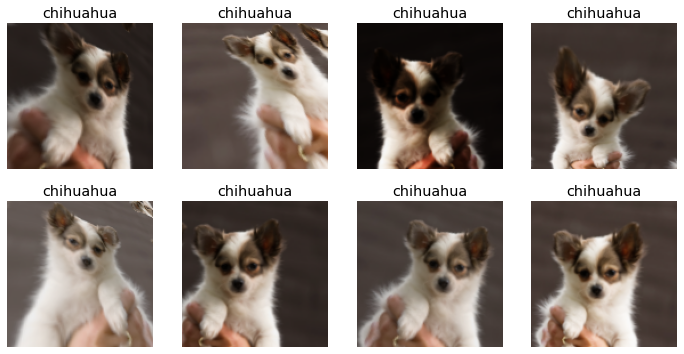

In [15]:
# aug_transforms provides standard set of data augmentations
# note that we switched back to Resize and did twice as much augmenting
# to make the output clearer for this example
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [16]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls=dogs.dataloaders(path)

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.363945,0.107513,0.057471,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.163562,0.016995,0.000000,00:18
1,0.134834,0.007043,0.000000,00:20
2,0.114846,0.006239,0.000000,00:19
3,0.093126,0.007102,0.000000,00:18


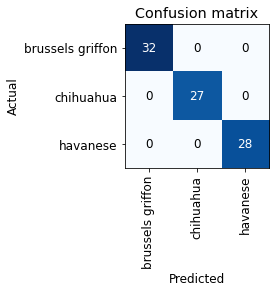

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

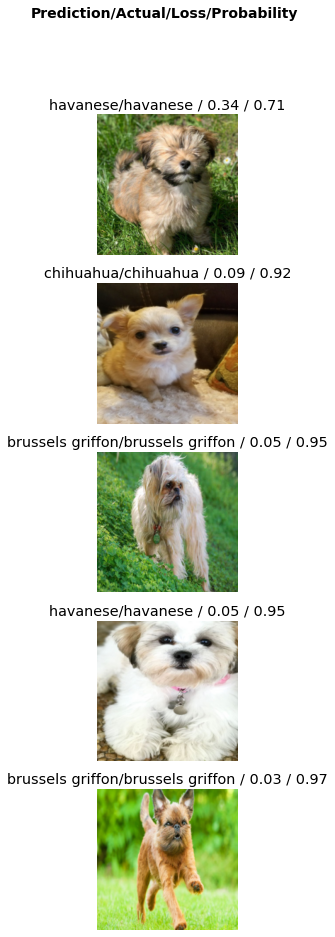

In [23]:
interp.plot_top_losses(5, nrows=5)

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [34]:
learn_inf.predict('images/brussels griffon dog.jpg')

('brussels griffon',
 TensorBase(0),
 TensorBase([9.9999e-01, 7.5892e-06, 3.7383e-06]))

In [35]:
learn_inf.dls.vocab

['brussels griffon', 'chihuahua', 'havanese']

In [36]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [39]:
img = PILImage.create(btn_upload.data[-1])

In [49]:
out_p1 = widgets.Output()
out_p1.clear_output()
with out_p1: display(img.to_thumb(128,128))
out_p1

Output()

In [41]:
pred,pred_idx,probs = learn_inf.predict(img)

In [50]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: brussels griffon; Probability: 0.9993')

In [53]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [55]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_p1.clear_output()
    with out_p1: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [54]:
VBox([widgets.Label('Upload a dog photo:'), btn_upload, btn_run, out_p1, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila